In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

DATA_DIM = 2

In [2]:
# data generation stuff
def generate_3circles_data(n_samples):
    """Generate 3 circles pattern data

    Args:
        n_samples (int): Number of samples to generate

    Returns:
        data (tuple):
            X (np-array): x, y positions
            y (np-array): classes
    """
    centers = np.array([[-1, 1], [1, 0], [-.5, -.5]])
    radii = np.array([1, np.sqrt(6/np.pi - 1), 1/2]) 
    points=[]
    classes=[]
    dim = 2
    for i in range(n_samples):
        X = 2 * (np.random.rand(dim)) - 1
        y = 0
        for j, (c, r) in enumerate(zip(centers, radii)): 
            if np.linalg.norm(X - c) < r:
                y = j + 1 
                
        points.append(X)
        classes.append(y)

    data = np.array(points), np.array(classes)
    settings = centers, radii             
    
    return data, settings


def generate_annulus_data(samples):
    """Generate the annulus pattern (tricrown) data

    Args:
        n_samples (int): Number of samples to generate

    Returns:
        data (tuple):
            X (np-array): x, y positions
            y (np-array): classes
    """
    centers = [[0,0],[0,0]]
    radii = [np.sqrt(.8 - 2/np.pi), np.sqrt(.8)]
    points=[]
    classes=[]
    dim = 2
    for i in range(samples):
        X = 2 * (np.random.rand(dim)) - 1
        y=0
        for j,(r,c) in enumerate(zip(radii, centers)):
            if np.linalg.norm(X - c) > r:
                y = j + 1
        points.append(X)
        classes.append(y)

    data = np.array(points), np.array(classes)
    settings = centers, radii  

    return data, settings

In [3]:
def get_Rx01(theta):
  return np.array([[np.cos(theta/2), -1j*np.sin(theta/2), 0], \
                   [-1j*np.sin(theta/2), np.cos(theta/2), 0], \
                   [0, 0, 1]])

def get_Ry01(theta):
  return np.array([[np.cos(theta/2), -1*np.sin(theta/2), 0], \
                   [np.sin(theta/2), np.cos(theta/2), 0], \
                   [0, 0, 1]])

def get_Rx12(theta):
  return np.array([[1, 0, 0], \
                   [0, np.cos(theta/2), -1j*np.sin(theta/2)], \
                   [0, -1j*np.sin(theta/2), np.cos(theta/2)]])

def get_Ry12(theta):
  return np.array([[1, 0, 0], \
                   [0, np.cos(theta/2), -1*np.sin(theta/2)], \
                   [0, np.sin(theta/2), np.cos(theta/2)]])

def get_layer(params):
  # Rx01 Ry01 Rx12 Ry12
  U = np.eye(3)
  return get_Rx01(params[0]) @ get_Ry01(params[1]) @ get_Rx12(params[2]) @ get_Ry12(params[3])


def get_model(params):
  # params: (list) each entry is iteratble of four angles
  U = np.eye(3)
  for i in range(0, len(params), 4):
    U = np.dot(get_layer(params[i:i+4]), U)
  return U

def eval_point(x, y, W, b):
  # W: (array) num_layers*4-by-dim_data
  # b: (array) num_layers*4-by-1

  # compute angles from data
  params = W @ x + b

  # get model given angles
  U = get_model(params)

  # apply model to [1, 0, 0]
  state = U @ np.array([1, 0, 0])
  
  # fidelity
  fidelity = state[y] * state[y].conj()
  return fidelity.real

def parse_params(params, num_layers, data_dim):
  W = params[:num_layers*4*data_dim].reshape((num_layers*4, data_dim))
  b = params[num_layers*4*data_dim:]
  return W, b

def eval(params, xs, ys, num_layers):
  W, b = parse_params(params, num_layers, DATA_DIM)
  loss = 0
  for x,y in zip(xs, ys):
    loss += 1 - eval_point(x, y, W, b)
  return loss

def store_loss(x, state):
  return state.fun

def train(xs, ys, num_layers):
  init_params = 2 * np.random.rand(num_layers*4*(DATA_DIM+1)) - 1
  result = minimize(eval, init_params, args=(xs, ys, num_layers), method="L-BFGS-B")#, callback=(store_loss))
  if not result.success:
    print("something went wrong")
  return result

def predict(params, xs, num_layers):
  W, b = parse_params(params, num_layers, DATA_DIM)
  ys = []
  for x in xs:
    # compute angles from data
    params = W @ x + b

    # get model given angles
    U = get_model(params)

    # apply model to [1, 0, 0]
    state = U @ np.array([1, 0, 0])

    amps = state * state.conj()
    ys.append(np.argmax(amps))
  return ys

In [4]:
data, settings = generate_annulus_data(600)

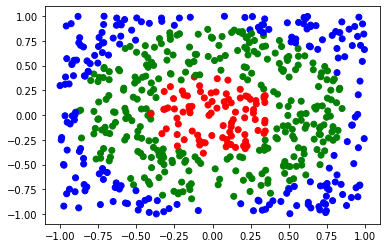

In [5]:
colors = ['red','green','blue']

plt.scatter(data[0][:, 0], data[0][:, 1], c=data[1], cmap=matplotlib.colors.ListedColormap(colors))

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.8)

In [7]:
results = train(x_train, y_train, 3)

In [8]:
params = results.x
ys = predict(params, x_test, 3)

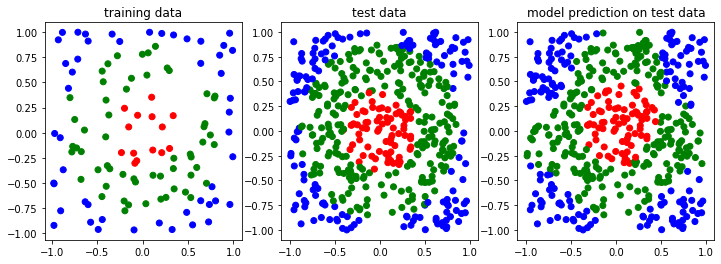

In [9]:
colors = ['red','green','blue']
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("training data")
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors))

plt.subplot(132)
plt.title("test data")
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=matplotlib.colors.ListedColormap(colors))

plt.subplot(133)
plt.title("model prediction on test data")
plt.scatter(x_test[:,0], x_test[:, 1], c=ys, cmap=matplotlib.colors.ListedColormap(colors))

In [10]:
# sweep over layer number
nlayers = np.arange(1, 6, dtype=int)
accuracy = np.zeros(len(nlayers))

for i, n in enumerate(nlayers):
  results = train(x_train, y_train, n)
  params = results.x
  ys = predict(params, x_test, n)
  accuracy[i] = (ys == y_test).sum() / len(y_test)
  print(f"Number of layers: {n} - accuracy: {accuracy[i]}")

Number of layers: 1 - accuracy: 0.51875
Number of layers: 2 - accuracy: 0.81875
Number of layers: 3 - accuracy: 0.8666666666666667
Number of layers: 4 - accuracy: 0.9104166666666667
something went wrong
Number of layers: 5 - accuracy: 0.9333333333333333


Text(0, 0.5, 'accuracy')

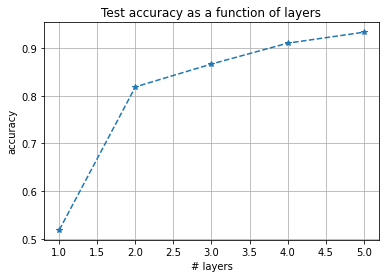

In [11]:
plt.plot(nlayers, accuracy, "*--")
plt.grid()
plt.title("Test accuracy as a function of layers")
plt.xlabel("# layers")
plt.ylabel("accuracy")